# Comparing classifiers in classy colors, code, scikit

A good guide has lots of practical advice and interesting visual aids. This makes the [classifiers comparison demo](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) extremely cool. It makes me green with envy.

scikit's classifier demo is a bit light on explanation though, so I've decided to expand the guide in more detail, helping someone new to python get into the classifier playground.

Here is what I cover

1. Preparing data for classification
    1. Code data with a test condition
    2. Code data by labels
2. Generating data for playing around
    1. The moons and circles
    2. Preparing convenience functions
    3. Adding polynomials
3. Playing with classifiers and decision boundaries
    1. Logistic regression
    2. Decision trees
    3. AdaBoost
    4. Random Foretsts
    5. Nearest neighbors
    6. Neural networks

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification, make_circles, make_moons
from sklearn.preprocessing import PolynomialFeatures

# Get some ways of evaluating models
from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt
import numpy as np

## Setting up classification data

When you're running data with classes, you want them to be in the format `0 False` and `1 True`.

For example, if you're testing whether apples are fresh or not, you would want `0 = not fresh` and `1 = fresh`. This is known as [binary classification](https://en.wikipedia.org/wiki/Binary_classification). Binary classes can also appear as $X$ variables.

In another instance, you may be classifying into multiple classes, such as predicting the color of apples. In this case you would want `(1,0,0) = red`, `(0,1,0) = yellow`, and `(0,0,1) = green`: all number as $0$ except the `True` class. These are known as [one-hot vectors](https://en.wikipedia.org/wiki/One-hot). They too can appear as $X$ variables.

### Binary coding by testing condition

You can transform data into 1s and 0s by testing them against a condition. This is done with numpy's [`np.where()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html) function.

`np.where()`'s syntax is `np.where(<boolean array-like>, value when True, value when False)`.

In [2]:
source_data = np.array(["green", "red", "yellow", "red", "blue"])

# Just to show you that this does indeed output a boolean array
print(source_data == "red")

# Using np.where()
print(np.where(source_data == "red", 1, 0))

# Just to ensure it works with scikit-learn
print(np.where(source_data == "red", 1, 0).reshape((-1,1)))

[False  True False  True False]
[0 1 0 1 0]
[[0]
 [1]
 [0]
 [1]
 [0]]


This technique also works with numeric data and more complex conditions; however, you need to use the [`np.logical_or()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.logical_or.html) function here. You can find the other numpy logical operators [here](https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.logic.html#logical-operations).

In [3]:
source_data = np.array([1.2, 4.6, -3.2, 6.1, -0.1])

print(np.where(np.logical_or(source_data > 5, source_data < 0), 1, 0).reshape((-1,1)))

[[0]
 [0]
 [1]
 [1]
 [1]]


### Multi-class with or without IDs

When dealing with mutliple classes, you might not have the IDs ready. As long as you're able to setup a `label_2_id` dictionary (given a label, returns an ID number) and an `id_2_label` list (given an integer, retrieve label as the index), you'll be able to switch between label and one-hot vector at will.

Before anything else, we do need to figure out the number of classes we have. This can be done with the [`set`](https://docs.python.org/3/tutorial/datastructures.html#sets) datatype. It's basically a python dictionary without keys, but this ends up useful since it eliminates all duplicates.

If you convert the `set` into a `list` with the [`list()`](https://docs.python.org/3/library/functions.html#func-list) function, you effectively create the `id_2_label` list. All it is is a list of unique labels. vector for $k$. I found this [clever technique on Stack Overflow](https://stackoverflow.com/a/37323404).

To create the `label_2_id` dictionary we take advantage of the [`dict()`](https://docs.python.org/3/library/stdtypes.html#dict) function for creating dictionaries. It lets you assign a dicionary by bulk. We feed the unique labels as the `keys` and a `range()` as the `values`. That creates the `label_2_id` dictionary nicely.

(In case I've never explained the [`range()`](https://docs.python.org/3/library/functions.html#func-range) function, it returns a list of incrementing integers.)

To create one-hot vectors, you can use the [`np.eye()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.eye.html).

The `np.eye()` function creates diagonal matrices, so how does this work? You can take advantage of numpy's indexing to index by the ID number of each data point. Since an ID number $k$ is an integer, it will select row $k$ of the diagonal matrix, which happens to also be the one-hot

In [4]:
source_data = [1, 2, 4, 8, 2, 4, 6, 8, 1, 2]

# This is what a set is like
print(set(source_data))

set_data = set(source_data)

# Now we can know the number of classes
n_classes = len(set_data)

# It's a good idea to have a way of converting back from IDs
id_2_label = list(set_data)

# We pull off another trick to assign IDs to the classes
label_2_id = dict(zip(set_data, range(n_classes)))

# We assign the IDs
id_data = [label_2_id[x] for x in source_data]

one_hots = np.eye(n_classes)[id_data]
print(one_hots)

{1, 2, 4, 6, 8}
[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]]


When you want to convert back from one-hot vectors into labels, you can use the `np.argmax()` function.

In [5]:
# I have a list comprehension addiction
print([id_2_label[x] for x in np.argmax(one_hots, axis=1)])

[1, 2, 4, 8, 2, 4, 6, 8, 1, 2]


## Generating data and such

### The moons and circles

There are two fun datasets to play with using classifiers. They both have non-linear boundaries, so they test the power of the classifiers.

The [`make_moons()`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function creates a dataset with interlocking moons, and the [`make_circles()`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html) function makes one ring contained within another.

In [6]:
X, y = make_moons(n_samples=1000, noise=0.25)
#X, y = make_circles(n_samples=1000, noise=0.2)

X_train = X[:500,0:2]
y_train = np.array(y)[:500]
print(X_train.shape)
print(y_train.shape)

X_valid = X[500:1000,0:2]
y_valid = np.array(y)[500:1000]
print(X_valid.shape)
print(y_valid.shape)

(500, 2)
(500,)
(500, 2)
(500,)


Here is what the data looks like.

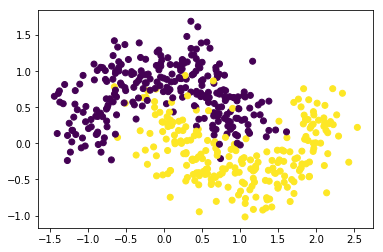

In [7]:
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)

plt.show()

### Convenience functions

To make our lives easier, we'll create some helper functions to fit and graph various classifiers to the data. I'll describe the functions involved one-by-one.

The main goal of the `decision_boundary()` function below is to plot class probabilities onto a 2D graph, with darker areas favouring one class and lighter areas favouring the other.

The [`np.arange()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.arange.html) function (not to be misread as *arrange*) is the numpy equivalent of the base python [`range()`](https://docs.python.org/3/library/functions.html#func-range). Below we feed it a starting point, an end point, and a value to increment by, and it will return a sequence of floats.

With these two sequences (1D arrays) we can use the [`np.meshgrid()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.meshgrid.html) function to generate a series of coordinates for the model to predict.

I use the `classifier.predict_proba()` function here because I prefer seeing a softer decision boundary rather than a hard one. Some of the classifiers below have sharp boundaries while other don't. The `classifier.predict_proba()` function is available on all scikit-learn classifier methods, so it can be used freely.

A good part of the code below comes from the [classifiers example](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html).

In [8]:
def decision_boundary(X, y, classifier, poly=None, soft=True, size=8, pointer_size=20, show=True, title=None):
    if size:
        plt.figure(figsize=(size, size))
    if title:
        plt.title(title)
    xx1_min, xx1_max = X[:,0].min() - .5, X[:,0].max() + .5
    xx2_min, xx2_max = X[:,1].min() - .5, X[:,1].max() + .5
    xx1, xx2 = np.meshgrid(np.arange(xx1_min, xx1_max, 0.01), 
                            np.arange(xx2_min, xx2_max, 0.01))
    if poly:
        grid_xx = poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()])
    else:
        grid_xx = np.c_[xx1.ravel(), xx2.ravel()]
    Zprobs = classifier.predict_proba(grid_xx)[:, 1].reshape(xx1.shape)
    Zmax = classifier.predict(grid_xx).reshape(xx1.shape)
    if soft:
        out = plt.contourf(xx1, xx2, Zprobs, cmap=plt.cm.binary, alpha=1.0)
        out = plt.contourf(xx1, xx2, Zmax, cmap=plt.cm.rainbow, alpha=0.1)
    else:
        out = plt.contourf(xx1, xx2, Zmax, cmap=plt.cm.binary, alpha=1.0)        
    plt.scatter(X[:,0], X[:,1], c=y, s=pointer_size, cmap=plt.cm.rainbow, alpha=0.5)
    if show:
        plt.show()

def score_model(classifier, poly=None):
    if poly:
        predict_train = classifier.predict(poly.fit_transform(X_train))
        predict_valid = classifier.predict(poly.fit_transform(X_valid))
    else:
        predict_train = classifier.predict(X_train)
        predict_valid = classifier.predict(X_valid)

    print("train accuracy : {0}".format(accuracy_score(y_train, predict_train)))
    print("valid accuracy : {0}".format(accuracy_score(y_valid, predict_valid)))
    print(classification_report(y_valid, predict_valid))

### Generating polynomials quickly

Scikit-learn offers you the [`PolynomialFeatures()`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) function to make your life easier here. It will transform any numpy input data into a new dataset with interactions and polynomials. You use it by instantiating it first and then feeding it data with `.fit_transform`.

We have to apply this transformation to the `meshgrid` data being predicted as well, so I went back and added a `poly=` argument to the `decision_boundary` function.

In [9]:
# The default options will give us (1, a, b, a*b, a**2, b**2)
poly3 = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
p3X_train = poly3.fit_transform(X_train)
p3X_valid = poly3.fit_transform(X_valid)

# Here are second-order polynomials
poly2 = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

p2X_train = poly2.fit_transform(X_train)
p2X_valid = poly2.fit_transform(X_valid)

## Testing classifiers by visualizing decision boundaries

### Logistic regression

The logistic regression fits a decision boundary that is a straight line, which will be "soft" thanks to the logistic/sigmoid the predictions pass through.

If this example is run on the `moons` data, it won't perform terribly; however, the logistic regression will do badly on the `circles` data.

train accuracy : 0.864
valid accuracy : 0.862
             precision    recall  f1-score   support

          0       0.86      0.85      0.85       236
          1       0.87      0.88      0.87       264

avg / total       0.86      0.86      0.86       500



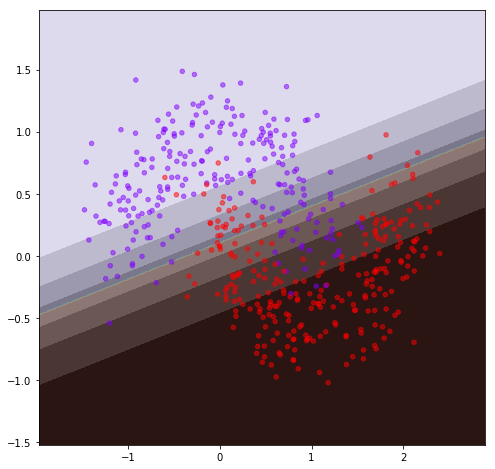

In [10]:
log = LogisticRegression()

log_fit = log.fit(X_train, y_train)

score_model(log)
decision_boundary(X_valid, y_valid, log)

There is one way of fixing this. If we add 2nd and 3rd order polynomials of the $X$ data, the logistic regression will become a lot better at predicting both the `moons` and the `circles` datasets.

When we run the logistic with these, it gets a lot better.

train accuracy : 0.944
valid accuracy : 0.936
             precision    recall  f1-score   support

          0       0.95      0.92      0.93       236
          1       0.93      0.95      0.94       264

avg / total       0.94      0.94      0.94       500



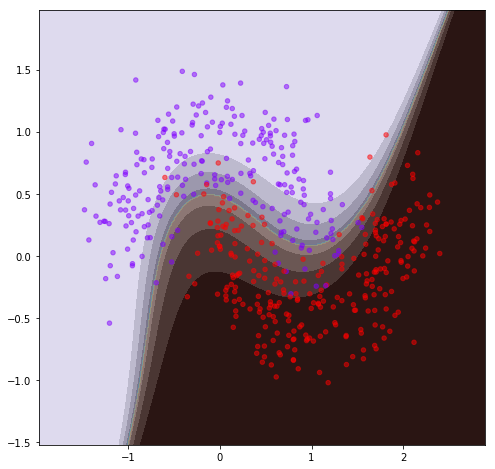

In [11]:
log = LogisticRegression()

log_fit = log.fit(p3X_train, y_train)

score_model(log, poly=poly3)
decision_boundary(X_valid, y_valid, log, poly=poly3)

### Decision trees

[scikit-learn's explanation](http://scikit-learn.org/stable/modules/tree.html) with advantages and disadvantages of decision trees

[Wikipedia article](https://en.wikipedia.org/wiki/Decision_tree_learning)

Decision trees are an iterative model. They start by slipping the data in two in such a way to best predict the classes. It then splits one of these halves in order to best improve the predictions, and so on. This keeps going until the data is perfectly split: decision trees overfit by default.

You can see this in action by incrementing through the `max_leaf_nodes` argument. It sets the maximum amount of times the tree can split the data.

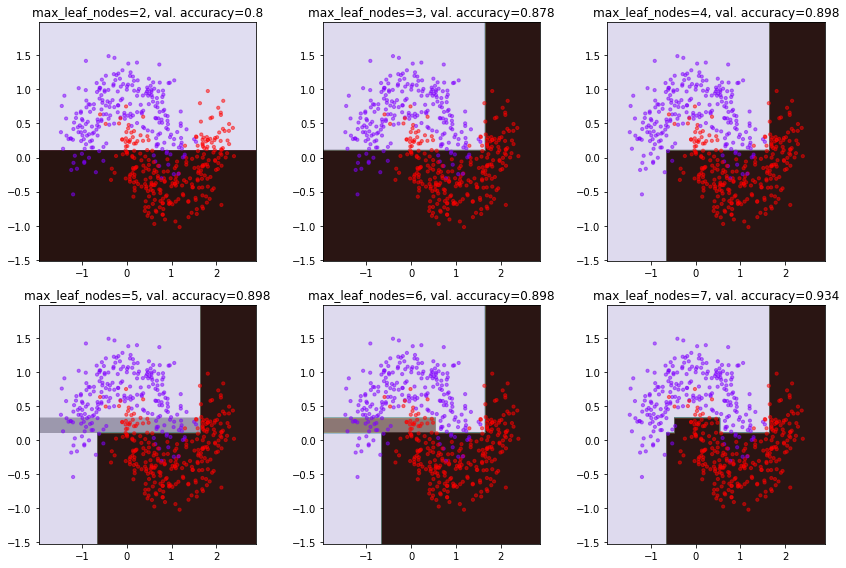

In [12]:
plt.figure(figsize=(12, 8))

for i in range(6):
    _ = DecisionTreeClassifier(max_leaf_nodes=i+2)
    _fit = _.fit(X_train, y_train)
    plt.subplot(2, 3, i+1)
    valid_accuracy = accuracy_score(y_valid, _.predict(X_valid))
    decision_boundary(X_valid, y_valid, _, size=None, pointer_size=10, 
                      show=False, title="max_leaf_nodes={0}, val. accuracy={1}".format(i+2, valid_accuracy))

plt.tight_layout()
plt.show()

When you run the `DecisionTreeClassifier` without a maximum, it will keep splitting the data until it's completely separated. You can see this in the `train_accuracy`: it's at 100%.

train accuracy : 1.0
valid accuracy : 0.918
             precision    recall  f1-score   support

          0       0.95      0.88      0.91       236
          1       0.90      0.95      0.92       264

avg / total       0.92      0.92      0.92       500



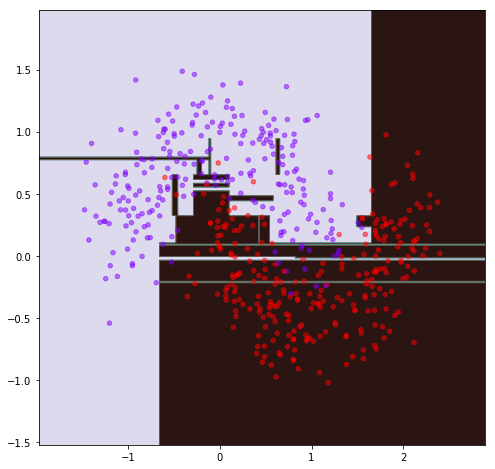

In [13]:
tree = DecisionTreeClassifier()

tree_fit = tree.fit(X_train, y_train)

score_model(tree)
decision_boundary(X_valid, y_valid, tree)

The decision trees work by feature selection: they choose a few features to split by. This doesn't apply above since we only have two variables, but it can come into play when we add polynomials.

With the 2nd order polynomial terms, the decision tree can now choose curved boundaries

train accuracy : 1.0
valid accuracy : 0.908
             precision    recall  f1-score   support

          0       0.93      0.87      0.90       236
          1       0.89      0.94      0.92       264

avg / total       0.91      0.91      0.91       500



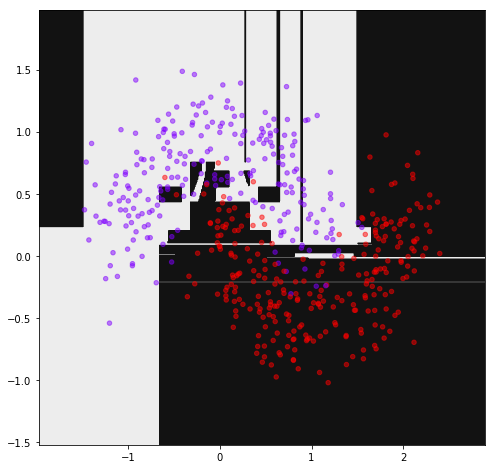

In [14]:
tree = DecisionTreeClassifier()

tree_fit = tree.fit(p2X_train, y_train)

score_model(tree, poly=poly2)
decision_boundary(X_valid, y_valid, tree, poly=poly2, soft=False)

### Adaboost

One way of making tree overfit less is the `AdaBoostClassifier`, which by default "boosts" the `DecisionTreeClassifier` (you can boost other models if you want).

The AdaBoost algorithm works by running the "weak classifier" on a sampled dataset first. It will keep doing this for each estimator, but will "adapt" itself each time by adjusting sampling weights.

This means that the path taken by the ensemble of classifiers will end up being different than the path taken by a lone classifier (it'll be tempted to split the data differently).

The classifier will overfit less since it won't have full and reliable access to the training data. By only seeing pieces of it, it'll only be able to overfit bits and pieces. When the "weak classifiers" are combined, they'll end up doing reasonably well (but will fit the data less well).

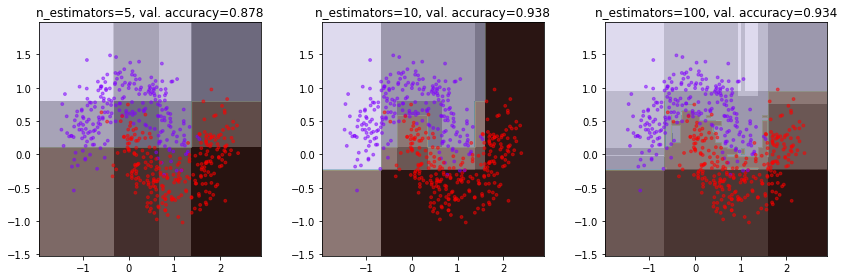

In [15]:
plt.figure(figsize=(12, 4))

for n, i in zip((5, 10, 100), (1, 2, 3)):
    _ = AdaBoostClassifier(n_estimators=n)
    _fit = _.fit(X_train, y_train)
    plt.subplot(1, 3, i)
    valid_accuracy = accuracy_score(y_valid, _.predict(X_valid))
    decision_boundary(X_valid, y_valid, _, soft=True, size=None, pointer_size=8, 
                      show=False, title="n_estimators={0}, val. accuracy={1}".format(n, valid_accuracy))

plt.tight_layout()
plt.show()

### Random Forests

[scikit-learn's guide on random forests](http://scikit-learn.org/stable/modules/ensemble.html#forest)

[Wikipedia article on random forests](http://scikit-learn.org/stable/modules/ensemble.html#forest)

The [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) class

The random forest method is similar to Adaboost in that they're both ensemble methods: they combine a lot of decision tree classifiers together. Random forests are different in that they repeatedly "bootstrap" sample the data and then aggregate the resulting models. Also, their decision trees randomly subset features at each node to further reduce overfitting (this is a non-default option in DecisionTree classifiers).

As you can see below, adding a lot of estimators ends up helping validation accuracy.

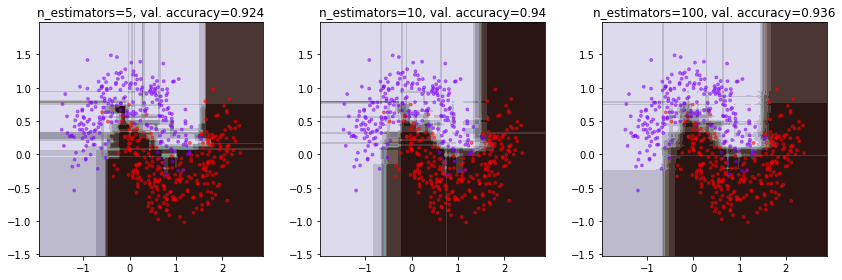

In [16]:
plt.figure(figsize=(12, 4))

for n, i in zip((5, 10, 100), (1, 2, 3)):
    _ = RandomForestClassifier(n_estimators=n)
    _fit = _.fit(X_train, y_train)
    plt.subplot(1, 3, i)
    valid_accuracy = accuracy_score(y_valid, _.predict(X_valid))
    decision_boundary(X_valid, y_valid, _, soft=True, size=None, pointer_size=8, 
                      show=False, title="n_estimators={0}, val. accuracy={1}".format(n, valid_accuracy))

plt.tight_layout()
plt.show()

The maximum depth of the trees can also be adjusted, but as you can see, the forest resists overfitting.

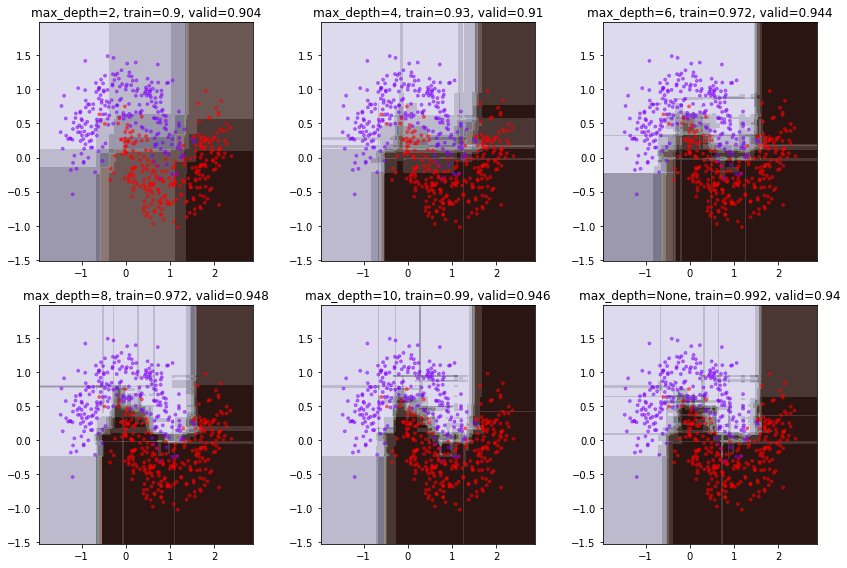

In [17]:
plt.figure(figsize=(12, 8))

for n, i in zip((2, 4, 6, 8, 10, None), (1, 2, 3, 4, 5, 6)):
    _ = RandomForestClassifier(max_depth=n, n_estimators=10)
    _fit = _.fit(X_train, y_train)
    plt.subplot(2, 3, i)
    valid_accuracy = accuracy_score(y_valid, _.predict(X_valid))
    train_accuracy = accuracy_score(y_train, _.predict(X_train))
    decision_boundary(X_valid, y_valid, _, soft=True, size=None, pointer_size=8, 
                      show=False, title="max_depth={0}, train={1}, valid={2}".format(n, train_accuracy, valid_accuracy))

plt.tight_layout()
plt.show()

### Nearest neighbors

[scikit-learn's introduction to nearest neighbors](http://scikit-learn.org/stable/modules/neighbors.html)

The nearest neighbors model is technically not a supervised learning algorithm, despite appearances. It works by simply finding the $k$ most similar datapoints in its training dataset and returning their average.

The average can either be uniform (equally weighted) or weighted by the inverse of the distance between points. When the average is inversely weighted, the KNN model will favor closest datapoints more than distant ones.

train accuracy : 1.0
valid accuracy : 0.916
             precision    recall  f1-score   support

          0       0.93      0.89      0.91       236
          1       0.91      0.94      0.92       264

avg / total       0.92      0.92      0.92       500



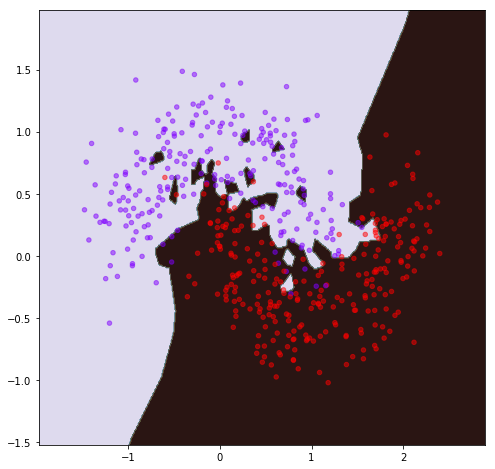

In [18]:
knn1 = KNeighborsClassifier(n_neighbors=1)

knn1_fit = knn1.fit(X_train, y_train)

score_model(knn1)
decision_boundary(X_valid, y_valid, knn1)

train accuracy : 0.952
valid accuracy : 0.966
             precision    recall  f1-score   support

          0       0.97      0.96      0.96       236
          1       0.97      0.97      0.97       264

avg / total       0.97      0.97      0.97       500



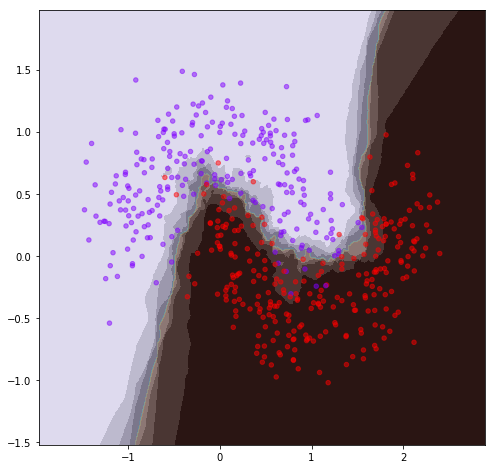

In [19]:
knn10 = KNeighborsClassifier(n_neighbors=10)

knn10_fit = knn10.fit(X_train, y_train)

score_model(knn10)
decision_boundary(X_valid, y_valid, knn10)

As we increase the number of neighbors, you can see that the decision boundary gets too smooth. This can be helped by weighing the neighbor distances, but this isn't a guaranteed fix.

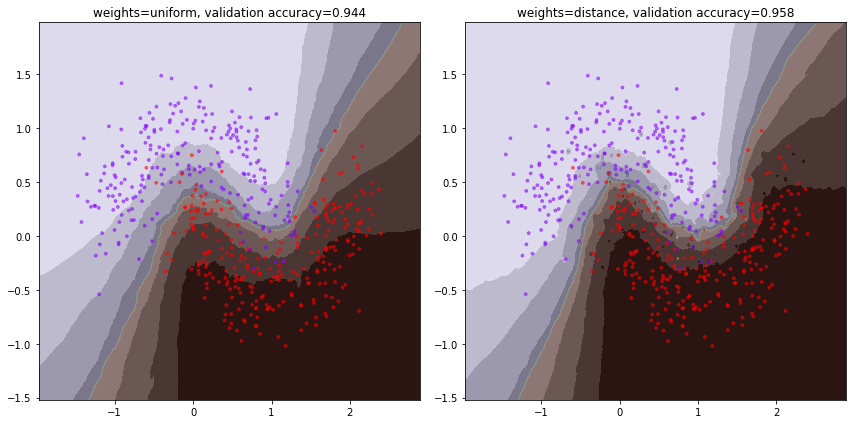

In [20]:
plt.figure(figsize=(12, 6))

for w, i in zip(('uniform', 'distance'), (1, 2)):
    _ = KNeighborsClassifier(n_neighbors=100, weights=w)
    _fit = _.fit(X_train, y_train)
    plt.subplot(1, 2, i)
    valid_accuracy = accuracy_score(y_valid, _.predict(X_valid))
    decision_boundary(X_valid, y_valid, _, size=None, pointer_size=8, 
                      show=False, title="weights={0}, validation accuracy={1}".format(w, valid_accuracy))

plt.tight_layout()
plt.show()

### Neural networks

[scikit-learn's guide on neural networks](http://scikit-learn.org/stable/modules/neural_networks_supervised.html)

Neural networks are multiple layers of multiple classifiers working together to classify data. This multi-layer approach makes neural networks extremely non-linear.

Here we use the [`MLPClassifier()`](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html), which is the "classic" feed forward neural network. scikit-learn includes some options by default, such as the [ReLU](https://en.wikipedia.org/wiki/Rectifier_&lpar;neural_networks&rpar;) activation function, the [Adam optimizer](http://ruder.io/optimizing-gradient-descent/index.html#adam), [L2](https://stats.stackexchange.com/a/45644) regularization of 0.0001, and [momentum](http://cs231n.github.io/neural-networks-3/#sgd) of 0.9.

/home/toaster/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


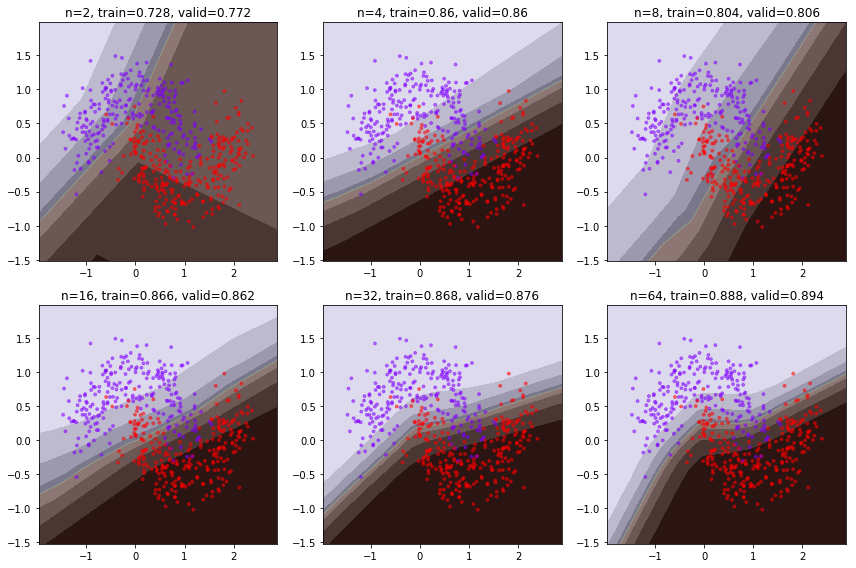

In [21]:
plt.figure(figsize=(12, 8))

for n, i in zip((2, 4, 8, 16, 32, 64), (1, 2, 3, 4, 5, 6)):
    _ = MLPClassifier(hidden_layer_sizes=(n,), activation="relu", solver="adam", alpha=0.0001, momentum=0.9)
    _fit = _.fit(X_train, y_train)
    plt.subplot(2, 3, i)
    valid_accuracy = accuracy_score(y_valid, _.predict(X_valid))
    train_accuracy = accuracy_score(y_train, _.predict(X_train))
    decision_boundary(X_valid, y_valid, _, size=None, pointer_size=8, 
                      show=False, title="n={0}, train={1}, valid={2}".format(n, train_accuracy, valid_accuracy))

plt.tight_layout()
plt.show()

The power of neural networks come from their layers: the more layers, the more non-linearity. You can see below how adding extra hidden layers helps the model adapt a lot faster.

/home/toaster/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


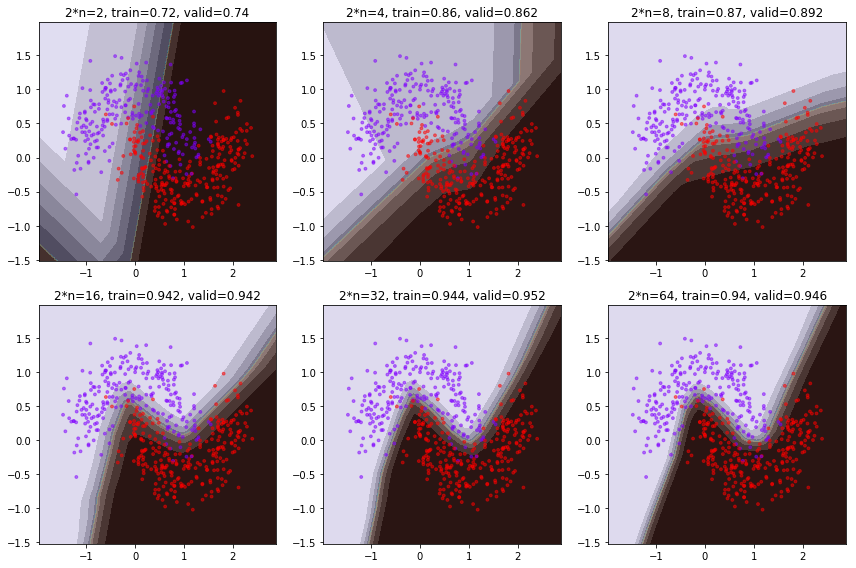

In [22]:
plt.figure(figsize=(12, 8))

for n, i in zip((2, 4, 8, 16, 32, 64), (1, 2, 3, 4, 5, 6)):
    _ = MLPClassifier(hidden_layer_sizes=(n,n,), activation="relu", solver="adam", alpha=0.0001, momentum=0.9)
    _fit = _.fit(X_train, y_train)
    plt.subplot(2, 3, i)
    valid_accuracy = accuracy_score(y_valid, _.predict(X_valid))
    train_accuracy = accuracy_score(y_train, _.predict(X_train))
    decision_boundary(X_valid, y_valid, _, size=None, pointer_size=8, 
                      show=False, title="2*n={0}, train={1}, valid={2}".format(n, train_accuracy, valid_accuracy))

plt.tight_layout()
plt.show()

I hope this proved an interesting introduction to classifiers in scikit-learn!